# Data Preparation - IT2 - The grid code flow model

The purpose of this notebook is to create every single flow possible and preform them on the photo's. Then from that point on we can evaluate every single flow based on charachteristics or we could use it later in other techniques.

In [1]:
import cv2
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from itertools import product

In [2]:
# Define the path to the folder containing the images to be processed
folder_path = '../data/original'

# Define the path to the folder where the processed images will be saved
output_folder = '../data/processedGridsearch'

In [3]:
def load_images_from_folder(folder_path, extensions=('.png', '.jpg', '.jpeg', '.JPG')):
    """
    Load all image file paths from a specified folder that match the given file extensions.

    Parameters:
    folder_path (str): The path to the folder containing the images.
    extensions (tuple of str): A tuple of file extensions to filter the images by. 
                               Default is ('.png', '.jpg', '.jpeg', '.JPG').

    Returns:
    list: A list of full file paths to images in the folder that match the specified extensions.
    
    Raises:
    FileNotFoundError: If the specified folder does not exist.
    """

    # Check if the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The specified folder does not exist: {folder_path}")

    # List comprehension to gather all image paths with the specified extensions
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(extensions)]

    return image_paths

In [4]:
# Function to convert to gray scale
def load_and_preprocess_images(image_paths, resize_dim=(256, 256)):
    images = []
    image_ids = []

    # Initialize tqdm progress bar
    for path in tqdm(image_paths, desc="Loading and preprocessing images", unit="image"):
        img = cv2.imread(path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img_resized = cv2.resize(img_gray, resize_dim)  # Resize for consistency
        images.append(img_resized)
        image_ids.append(f'Image_{len(images)}')  # Assign image ID as Image_1, Image_2, etc.

    return images, image_ids

## Functions per step

### Step 1: Noise Reduction Techniques

In [5]:
# Noise Reduction Functions
def apply_gaussian_blur(image, ksize=(5, 5)):
    """Apply Gaussian Blur to reduce noise with the specified kernel size."""
    return cv2.GaussianBlur(image, ksize, 0)

def apply_median_blur(image, ksize=5):
    """Apply Median Blur to reduce salt-and-pepper noise with the specified kernel size."""
    return cv2.medianBlur(image, ksize)

def apply_non_local_means(image, h=10, templateWindowSize=7, searchWindowSize=21):
    """Apply Non-Local Means Denoising with specified parameters."""
    return cv2.fastNlMeansDenoising(image, None, h, templateWindowSize, searchWindowSize)

### Step 2: Histogram Equalization Techniques

In [6]:
# Histogram Equalization Functions
def apply_histogram_equalization(image):
    return cv2.equalizeHist(image)

def apply_clahe(image, clipLimit=2.0, tileGridSize=(8, 8)):
    """Apply CLAHE to enhance image contrast with specified parameters."""
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    return clahe.apply(image)

### Step 3: Binarization Techniques

In [7]:
# Binarization Functions
def apply_global_threshold(image, thresholdValue=127):
    """Apply Global Thresholding with the specified threshold value."""
    _, binary_image = cv2.threshold(image, thresholdValue, 255, cv2.THRESH_BINARY)
    return binary_image

def apply_adaptive_threshold(image, adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C, blockSize=11, C=2):
    """Apply Adaptive Thresholding with the specified method, block size, and constant C."""
    return cv2.adaptiveThreshold(image, 255, adaptiveMethod, cv2.THRESH_BINARY, blockSize, C)

def apply_otsu_threshold(image):
    """Apply Otsu Thresholding."""
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

# inverted otsu 

### Step 4: Morphological Operations Techniques

In [8]:
# Morphological Operations Functions
def apply_dilation(image, kernel_size=(5, 5)):
    """Apply Dilation with the specified kernel size."""
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.dilate(image, kernel, iterations=1)

def apply_erosion(image, kernel_size=(5, 5)):
    """Apply Erosion with the specified kernel size."""
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.erode(image, kernel, iterations=1)

def apply_opening(image, kernel_size=(5, 5)):
    """Apply Morphological Opening with the specified kernel size."""
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def apply_closing(image, kernel_size=(5, 5)):
    """Apply Morphological Closing with the specified kernel size."""
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

### Step 5: Edge Detection Techniques

In [9]:
# Edge Detection Functions
# unsharp masking

def apply_canny_edge(image, threshold1=50, threshold2=150):
    """Apply Canny Edge Detection with specified thresholds."""
    return cv2.Canny(image, threshold1, threshold2)

def apply_sobel_edge(image, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT):
    """Apply Sobel Edge Detection with specified parameters."""
    return cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=ksize, scale=scale, delta=delta, borderType=borderType)

## Grid search

## Possible flows/technique options

In [10]:
#listing the possible techniques
noise_reduction_techniques = ["None", 
                              {"func": "apply_gaussian_blur", "params": {"ksize": (3, 3)}}, 
                              {"func": "apply_gaussian_blur", "params": {"ksize": (5, 5)}}, 
                              {"func": "apply_gaussian_blur", "params": {"ksize": (7, 7)}}, 
                              {"func": "apply_median_blur", "params": {"ksize": 3}}, 
                              {"func": "apply_median_blur", "params": {"ksize": 5}}, 
                              {"func": "apply_median_blur", "params": {"ksize": 7}}, 
                              {"func": "apply_non_local_means", "params": {"h":7, "templateWindowSize":7, "searchWindowSize":21}}, 
                              {"func": "apply_non_local_means", "params": {"h":10, "templateWindowSize":7, "searchWindowSize":21}},
                              {"func": "apply_non_local_means", "params": {"h":15, "templateWindowSize":7, "searchWindowSize": 21}}]

histogram_equalization_techniques = ["None",
                                     "apply_histogram_equalization", 
                                    {"func": "apply_clahe", "params": {"clipLimit": 2.0, "tileGridSize": (8,8)}}, 
                                    {"func": "apply_clahe", "params": {"clipLimit": 2.0, "tileGridSize": (4,4)}}, 
                                    {"func": "apply_clahe", "params": {"clipLimit": 3.0, "tileGridSize": (8,8)}}]
binarization_techniques = ["None",
                              {"func": "apply_global_threshold", "params": {"thresholdValue": 100}}, 
                              {"func": "apply_global_threshold", "params": {"thresholdValue": 127}}, 
                              {"func": "apply_global_threshold", "params": {"thresholdValue": 150}},
                              {"func": "apply_adaptive_threshold", "params": {"adaptiveMethod": cv2.ADAPTIVE_THRESH_MEAN_C, "blockSize":11, "C":2}}, 
                              {"func": "apply_adaptive_threshold", "params": {"adaptiveMethod": cv2.ADAPTIVE_THRESH_MEAN_C, "blockSize":15, "C":4}}, 
                              {"func": "apply_adaptive_threshold", "params": {"adaptiveMethod": cv2.ADAPTIVE_THRESH_GAUSSIAN_C, "blockSize":11, "C":2}},
                           "apply_otsu_threshold"]
morphological_operations = ["None",
                              {"func": "apply_dilation", "params": {"kernel_size": (3, 3)}}, 
                              {"func": "apply_dilation", "params": {"kernel_size": (5, 5)}}, 
                              {"func": "apply_dilation", "params": {"kernel_size": (7, 7)}},
                              {"func": "apply_erosion", "params": {"kernel_size": (3, 3)}}, 
                              {"func": "apply_erosion", "params": {"kernel_size": (5, 5)}}, 
                              {"func": "apply_erosion", "params": {"kernel_size": (7, 7)}}, 
                              {"func": "apply_opening", "params": {"kernel_size": (3, 3)}}, 
                              {"func": "apply_opening", "params": {"kernel_size": (5, 5)}}, 
                              {"func": "apply_closing", "params": {"kernel_size": (3, 3)}}, 
                              {"func": "apply_closing", "params": {"kernel_size": (5, 5)}}]
edge_detection_techniques = ["None",
                                {"func": "apply_canny_edge", "params": {"threshold1": 50, "threshold2": 150}}, 
                                {"func": "apply_canny_edge", "params": {"threshold1": 30, "threshold2": 100}}, 
                                {"func": "apply_canny_edge", "params": {"threshold1": 70, "threshold2": 200}},
                                {"func": "apply_sobel_edge", "params": {"ksize": 3}},
                                {"func": "apply_sobel_edge", "params": {"ksize": 5}}, 
                                {"func": "apply_sobel_edge", "params": {"ksize": 7}}, 
                             ]

In [11]:
# Generate all possible flows (intertools is used here)
all_possible_flows = list(product(
    noise_reduction_techniques,
    histogram_equalization_techniques,
    binarization_techniques,
    morphological_operations,
    edge_detection_techniques
))

### Would not print this unless you are interested

In [12]:
# Prints all possible combinations of flows
print(f"Total number of flows: {len(all_possible_flows)}")
#for flow in all_possible_flows:
#   print(flow)

Total number of flows: 30800


## Applying the different options to an Image

In [13]:
# Load all image paths
image_paths = load_images_from_folder(folder_path)

# Select a random image path from the list
selected_image_path = [random.choice(image_paths)]  # Wrap in a list to keep input compatible

# Load and preprocess only the selected image
images, image_ids = load_and_preprocess_images(selected_image_path)

Loading and preprocessing images: 100%|██████████| 1/1 [00:00<00:00,  3.39image/s]


TypeError: expected str, bytes or os.PathLike object, not list

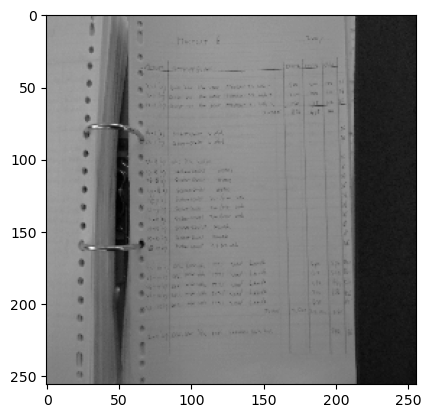

In [14]:
# Display the selected image
plt.imshow(images[0], cmap='gray')
plt.title(f"Selected Grayscale Image: {os.path.basename(selected_image_path)}")
plt.axis('off')
plt.show()

# Ensure selected_image_path contains the preprocessed image
image = images[0]  # Use the already preprocessed grayscale image

for idx, flow in enumerate(all_possible_flows, start=1):
    processed_image = image.copy()  # Start with a copy of the original image
    
    # Initialize the list to track applied techniques
    techniques_applied = []  
    
    for technique in flow:
        if technique != "None":
            if isinstance(technique, dict):  # Check if 'technique' is a dictionary
                func_name = technique["func"]
                params = technique.get("params", {})
            else:  # If it's a string (function name only), no parameters
                func_name = technique
                params = {}

            processed_image = globals()[func_name](processed_image, **params)  # Apply the function with parameters



    """DO NOT RUN THIS IT WILL CREATE 30800 IMAGES IN THE OUTFUR FOLDER"""
    # Create a filename based on the applied techniques
    #if techniques_applied:
        #filename = f"{'_'.join(techniques_applied)}.png"
    #else:
        #filename = "no_techniques_applied.png"

    # Save the processed image with the descriptive filename
    #output_path = os.path.join(output_folder, filename)
    #cv2.imwrite(output_path, processed_image)

print(f"All images are processed")

In [16]:
    total_flows_executed = 0    
    image = images[0]
    # Iterate over all possible flows with a progress bar
    for flow in tqdm(all_possible_flows, desc="Processing Flows", unit="flow"):
        processed_image = image.copy()  # Make a copy of the original image for each flow
        
        # Initialize a variable to track if any technique is applied in the current flow
        techniques_applied = []
        
        for technique in flow:
            if technique != "None":
                if isinstance(technique, dict):  # Check if 'technique' is a dictionary
                    func_name = technique["func"]
                    params = technique.get("params", {})
                else:  # If it's a string (function name only), no parameters
                    func_name = technique
                    params = {}

                # Apply the technique to the image
                processed_image = globals()[func_name](processed_image, **params)
                techniques_applied.append(func_name)  # Track applied techniques

        total_flows_executed += 1  # Increment the flow counter

    # Print out the total number of flows executed
    print(f"Total Flows Executed: {total_flows_executed}")

Processing Flows:  73%|███████▎  | 22444/30800 [02:16<00:50, 164.52flow/s] 


KeyboardInterrupt: 